In [1]:
%%time
# Import necessary Libraries
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import pickle # used to store cleaned data
import numpy.ma as ma # masking for numpy Arrays
boolVal = False
attedDataName = '../../project_data/Overlapping_GenesMR.p'
bioGRIDfileName = '../../project_data/BioGRID_with_ATTEDMR.p'
wholeAttedDataName = '../../project_data/AllAttedGenesMR.p'
AbcLtpDataName = '../../project_data/AbcLtpMRData.p'

if boolVal:
    # Reading in BioGRID as DataFrame
    bioGRID_file = '../../project_data/BIOGRID-ORGANISM-Arabidopsis_thaliana_Columbia-3.5.181.tab2.txt'
    bioGRID_DF = pd.read_csv(bioGRID_file, sep = '\t')
    # Simplified DataFrame to only include interactions
    simplebGRID = bioGRID_DF[['Entrez Gene Interactor A','Entrez Gene Interactor B']]
    # Identifying Organisms Present in BioGRID
    OrganismTypesA = list(bioGRID_DF['Organism Interactor A'].unique())
    OrganismTypesB = list(bioGRID_DF['Organism Interactor B'].unique())
    OrganismTypesA.sort()
    OrganismTypesB.sort()
    OrganismTypes = list(set([*OrganismTypesA, *OrganismTypesB]))
    OrganismTypes.sort()
    # Use NCBI's Taxonomy Name/ID Status Report - Plug in OrganismTypes and get .txt
    organismIDs = pd.read_csv('../../project_data/tax_report.txt', sep = '\t')
    organismIDs.drop(columns = ['|','|.1','|.2', 'code', 'primary taxid'],inplace = True)
    # Categorize into different subsets based on organism ID. We know '3702' is Arabidopsis
    mask1 = bioGRID_DF['Organism Interactor A'] == 3702
    mask2 = bioGRID_DF['Organism Interactor B'] == 3702
    onlyArabDF = bioGRID_DF[mask1& mask2]
    oneArabDF = bioGRID_DF[~mask1|~mask2]
    noArabDF = bioGRID_DF[~mask1 & ~mask2]
    # Get list of genes so I can import the necessary ATTED Data. Note that the ATTED data has a text file by Entrez gene ID
    # WholeData:
    wholeGenesA = list(bioGRID_DF['Entrez Gene Interactor A'].unique())
    wholeGenesB = list(bioGRID_DF['Entrez Gene Interactor B'].unique())
    wholeGenesA.sort()
    wholeGenesB.sort()
    wholeGenes = list(set([*wholeGenesA, *wholeGenesB]))
    wholeGenes.sort()
    # Only Arabidopsis Subset
    ArabGenesA = list(onlyArabDF['Entrez Gene Interactor A'].unique())
    ArabGenesB = list(onlyArabDF['Entrez Gene Interactor B'].unique())
    ArabGenesA.sort()
    ArabGenesB.sort()
    ArabGenes = list(set([*ArabGenesA, *ArabGenesB]))
    ArabGenes.sort()
    # Read in only the Overlapping Genes
    # Get a list of all genes in ATTED
    atted = pd.read_csv('../../project_data/Ath-mB.v17-08.G20819-S16033.rma_combat.mrgeo.d/814630', sep = '\t', header = None)
    atted = atted.sort_values(by = 0)
    a1 = np.array(atted[0])
    attedGenes = list(a1)
    # Reading in of Overlapping Genes
    attedpath = 'C:\\Users\\ysman\\OneDrive\\Desktop\\project_data\\Ath-mB.v17-08.G20819-S16033.rma_combat.mrgeo.d\\'
    overlapGenes = []
    for i in range (len(wholeGenes)):
        if os.path.exists(attedpath+'{}'.format(wholeGenes[i])):
            overlapGenes.append(wholeGenes[i])
    DF = {0:attedGenes}
    for x in overlapGenes:
        tempAtted = pd.read_csv('../../project_data/Ath-mB.v17-08.G20819-S16033.rma_combat.mrgeo.d/{}'.format(x), sep = '\t', header= None)
        tempAtted = tempAtted.sort_values(by = 0)
        templist = list(tempAtted[1])
        DF.update({x:templist})
    attedData = pd.DataFrame(DF,dtype='float64')
    attedData = attedData.astype({0:'int'})
    attedData = attedData.set_index(0)
    pickle.dump(attedData, open(attedDataName, 'wb'))
    # Add ATTED MR Values to BioGRID
    genesGRID = simplebGRID.loc[:]
    genesGRID['MR']=np.zeros(len(genesGRID))
    # for gA,gB in zip(toyGRID.iloc[:,0],toyGRID.iloc[:,1]): is a way to iterate through 2 cols at once
    for i in range(genesGRID.shape[0]):
        gA = genesGRID.loc[i,'Entrez Gene Interactor A']
        gB = genesGRID.loc[i,'Entrez Gene Interactor B']
        if (gA in attedData.columns) and (gB in attedData.columns): # checks if both genes are part of the overlapping set
            mr = attedData.loc[gA,gB]
            genesGRID.loc[i,'MR'] = mr
        else:
            genesGRID.loc[i,'MR'] = np.nan
    pickle.dump(genesGRID, open(bioGRIDfileName, 'wb'))
    # Create a DataFrame of all MR values in the ATTED data
    aDF = {0:attedGenes}
    for x in attedGenes:
        tempAtted = pd.read_csv('../../project_data/Ath-mB.v17-08.G20819-S16033.rma_combat.mrgeo.d/{}'.format(x), sep = '\t', header= None)
        tempAtted = tempAtted.sort_values(by = 0)
        templist = list(tempAtted[1])
        aDF.update({x:templist})
    wholeAttedData = pd.DataFrame(aDF,dtype='float64')
    wholeAttedData = wholeAttedData.astype({0:'int'})
    wholeAttedData = wholeAttedData.set_index(0)
    pickle.dump(wholeAttedData, open(wholeAttedDataName, 'wb'))
    
    boolVal = False
else:
    # Load data using pickle
    attedData = pickle.load(open(attedDataName, 'rb'))
    genesGRID = pickle.load(open(bioGRIDfileName, 'rb'))
    wholeAttedData = pickle.load((open(wholeAttedDataName, 'rb')))
# Initializes Networkx Graph
genesG = nx.Graph()
# Adds edges for each interaction
for i in range(genesGRID.shape[0]):
    genesG.add_edge(genesGRID['Entrez Gene Interactor A'].loc[i], genesGRID['Entrez Gene Interactor B'].loc[i], weight = genesGRID['MR'].loc[i])

def nonConvertible(orig,trans): 
    '''
    Checks if all orginal values are in new list of values 
    and returns the ones that aren't
    Inputs: List of original values, list of new values
    Output: List of all original values that are not in the new value list
    ''' 
    nc = []
    for i in range(len(orig)):
        if orig[i] not in trans:
            nc.append(orig[i])
        else:
            continue
    return nc

def existing(lst, reference): 
    '''
    Checks if items of lst are in reference, returns a list of existing values
    Inputs: List to check, list to cross-reference with
    Output: List of all values that also exist in the reference list.
    ''' 
    exists = [] # stores the existing values
    NE = [] # stores the non-existing values
    for x in lst:
        if x in reference:
            exists.append(x)
        else:
            NE.append(x)
    return exists, NE

def ShortestDistances(Graph,grpA,grpB,dataFrame = True): #using function caused Kernel to crash due to memory
    '''
    Finds the shortest distances in a graph between all members of group 1 
    and all members of group 2 and stores into a dict.
    Inputs: Graph to scan, list of group A nodes, list of group B nodes
    Output: Returns a pandas dataFrame with group A as columns and group B as rows 
            and the shortest-distance as the values. 
            Else, returns a dict with group A as keys and a list of shortest distances 
            as values (size of list is the length of group B)
    '''
    graphGenes = list(Graph.nodes)
    abc, Uabc = existing(grpA,graphGenes)
    ltp, Ultp = existing(grpB,graphGenes)
    DF={0:ltp}
    for x in abc:
        valList = []
        for y in ltp:
            if (x in graphGenes) and (y in graphGenes): # checks if both genes are part of the overlapping set
                val = nx.astar_path_length(Graph, x,y)
            else:
                val = np.nan
            valList.append(val)
        DF.update({x:valList})
    if dataFrame:
        Data = pd.DataFrame(DF,dtype='float64')
        Data = Data.astype({0:'int'})
        Data = Data.set_index(0)
        return Data
    else:
        return DF
# option: filter out nodes with 1 connection
# store as a dictionary, dict: 
def simplifyGraph(grpA, grpB, Graph, kdeg):
    '''
    Gathers all nodes within kdeg degrees of separation from the given groups.
    Inputs: list of group A nodes, list of group B nodes, graph to simplify, int representing
            the degree of seperation from the key nodes allow.
    Output: subgraph of inputted graph as well as dictionary with each node in the new graph as key
            and # of neighboring nodes in group A, # of neighboring nodes in group B, and 
            list of all neighboring nodes.
    '''
    keyGenes = sorted(set([*grpA,*grpB]))
    i = kdeg
    while i >0:
        # Stores neighbors at each key gene
        neighbors = []
        # Loops through all key genes 
        for gene in keyGenes:
            nodes = [n for n in Graph.neighbors(gene)]
            neighbors.append(nodes)
        neighbors.append(keyGenes)
        neighbors = [item for sublist in neighbors for item in sublist]
        keyGenes = sorted(set(neighbors))
        i-=1
    # Creates subgraph
    newGraph = Graph.subgraph(keyGenes)
    # Iterates through the new nodes and checks if neighbors are in either group A or B
    geneDict = {}
    for gene in newGraph.nodes:
        nodes = [n for n in newGraph.neighbors(gene)]
        grpACount = 0
        grpBCount = 0
        for ngene in nodes:
            if ngene in grpA:
                grpACount +=1
            elif ngene in grpB:
                grpBCount +=1
        geneDict[gene] = (grpACount,grpBCount, nodes)
    return newGraph, geneDict

# Read In Data 
ABC_trans = pd.read_csv('../data/convABC_Genes.txt', sep = '\t')
ABC_trans = ABC_trans.rename(columns = {'From':'TAIR_ID','To':'ENTREZ_ID'})
ABC_orig = pd.read_excel('../data/ABC_Genes.xls', sheet_name = 'Sheet2')
abcAT = sorted(set(list(ABC_trans['TAIR_ID'])))
abcEntrez = sorted(set(list(ABC_trans['ENTREZ_ID'])))
abcAT_orig = sorted(set(list(ABC_orig['TAIR_ID'])))
abc_NC  = nonConvertible(abcAT_orig,abcAT)
LTP_trans = pd.read_csv('../data/convLTP_Genes.txt', sep = '\t')
LTP_trans = LTP_trans.rename(columns = {'From':'TAIR_ID','To':'ENTREZ_ID'})
LTP_orig = pd.read_excel('../data/LTP_Genes.xlsx', sheet_name = 'Sheet1')
ltpAT = sorted(set(list(LTP_trans['TAIR_ID'])))
ltpEntrez = sorted(set(list(LTP_trans['ENTREZ_ID'])))
ltpAT_orig = sorted(set(list(LTP_orig['TAIR_ID'])))
ltp_NC  = nonConvertible(ltpAT_orig,ltpAT)
abc, Uabc = existing(abcEntrez,genesG.nodes)
ltp, Ultp = existing(ltpEntrez,genesG.nodes)

# Create MR values for all ABC and LTP genes in ATTED set.
newBool = False
attedAbc, attedUabc = existing(abcEntrez, wholeAttedData.columns)
attedLtp, attedUltp = existing(ltpEntrez, wholeAttedData.columns)
if newBool:
    mrDF = {0: attedLtp}
    for abc in attedAbc:
        tempMRs = []
        for ltp in attedLtp:
            if (abc in wholeAttedData.columns) and (ltp in wholeAttedData.columns):
                tempMR = wholeAttedData.loc[abc,ltp]
            tempMRs.append(tempMR)
        mrDF[abc] = tempMRs
    AbcLtpData = pd.DataFrame(mrDF,dtype='float64')
    AbcLtpData = AbcLtpData.astype({0:'int'})
    AbcLtpData = AbcLtpData.set_index(0)
    pickle.dump(AbcLtpData, open(AbcLtpDataName, 'wb'))
    newBool = False
else:
    AbcLtpData = pickle.load((open(AbcLtpDataName, 'rb')))

# Run Shortest Path & store as pickle files
simpleShortDistFileName = '../../project_data/simplifiedShortestDistances.p'
shortDistFileName = '../../project_data/shortestDistances.p'
'''
simpleG, simpleGDict = simplifyGraph(abc,ltp, genesG,1)
simple_abc_ltp_shortDist = ShortestDistances(genesG,abcEntrez,ltpEntrez, True)
pickle.dump(abc_ltp_shortDist, open(shortDistFileName, 'wb'))
simple_abc_ltp_shortDist = ShortestDistances(simpleG,abcEntrez,ltpEntrez, True)
pickle.dump(simple_abc_ltp_shortDist, open(simpleShortDistFileName, 'wb'))
'''
print(f'ATTED-compatible ABC Genes: {len(attedAbc)}/{len(abcEntrez)}')
print(f'ATTED-compatible LTP Genes: {len(attedLtp)}/{len(ltpEntrez)}')

ATTED-compatible ABC Genes: 103/129
ATTED-compatible LTP Genes: 55/85
Wall time: 23.5 s


In [3]:
genesGRID

,Entrez Gene Interactor A,Entrez Gene Interactor B,MR
0,828230,832208,269.13
1,828230,821860,1067.96
2,836259,818903,17306.01
3,836259,825075,20073.00
4,836259,836259,0.00
...,...,...,...
56193,838388,827028,94.99
56194,838388,821921,10774.35
56195,838388,828889,16288.84
56196,838388,836652,3316.84


In [6]:
len(set(genesG.edges()))

48981

In [33]:
AbcLtpData.head()

,814660,815414,815846,817232,817351,817544,818031,818211,818265,818275,...,841761,841775,841876,842281,842763,842852,843013,843122,843398,843527
0,,,,,,,,,,,,,,,,,,,,,
815994,2140.84,4590.38,2952.89,232.41,7515.29,11137.42,15541.52,19171.69,4846.70,7809.72,...,18145.46,9985.99,819.80,15302.60,16988.04,2574.78,17122.69,4803.20,2227.71,16872.34
816022,12592.33,9639.99,10091.00,15010.24,14611.32,3450.57,16207.66,17142.84,18684.08,646.41,...,3341.93,10974.43,13964.91,13200.80,17598.92,18614.13,3122.28,13523.59,11654.36,12990.09
816352,20379.43,13865.64,19550.99,19288.25,15563.17,12858.78,4862.30,1402.08,8925.40,11132.99,...,139.44,9693.23,19534.00,8655.75,15372.33,19086.77,3190.90,910.37,18061.91,1832.80
817255,7932.24,3995.69,3345.01,2602.29,5251.46,15654.74,16998.01,20079.92,4069.37,11111.13,...,14353.08,16605.73,1989.09,20458.25,10087.99,4715.58,14433.90,7484.44,6402.09,16328.64
817912,18739.37,14779.56,18555.45,18297.69,13843.45,19754.03,10894.70,6046.07,4244.11,19052.52,...,11751.07,5353.98,17876.68,6323.32,10619.05,4098.81,13232.89,134.06,20446.01,4466.86


In [88]:
def GetTopGenes(cutoff, attedAbc = attedAbc, attedLtp = attedLtp, wholeAttedData=wholeAttedData):
    '''
    Gathers all ABC/LTP gene interactions with MR values less than cutoff .
    Inputs: MR cutoff, list of Atted-compatible ABC genes, list of Atted-compatible LTP genes,
            ATTED Co-expression MR matrix.
    Output: list of tuples for each ABC/LTP interaction and dict with ABC genes as keys
            and LTP genes as values.
    '''
    closeGenes = []
    topGenes = {}
    for abc in attedAbc:
        closeLTPs = []
        for ltp in attedLtp:
            if wholeAttedData.loc[abc,ltp]<cutoff:
                closeGenes.append((abc,ltp))
                closeLTPs.append((ltp,wholeAttedData.loc[abc,ltp]))
        topGenes[abc] = closeLTPs
    numIter = len(closeGenes)
    uniqueGenes = sorted(set([gene for genes in closeGenes for gene in genes]))
    numUgenes = len(uniqueGenes)
    print(f'There are {numIter} interactions when applying a cutoff of less than {cutoff}.')
    print(f'There are {numUgenes} unique genes interacting with the given cutoff of less than {cutoff}.')
    return closeGenes,topGenes,uniqueGenes


In [89]:
closeGenes,topGenes,uniqueGenes = GetTopGenes(10)
topGenes.values()

There are 7 interactions when applying a cutoff of less than 10.
There are 11 unique genes interacting with the given cutoff of less than 10.


dict_values([[], [], [], [], [], [], [], [], [], [], [], [(820024, 7.03)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(837046, 4.61)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(819426, 9.94), (831237, 4.58)], [], [], [(831237, 9.15)], [], [], [], [], [], [], [], [], [], [], [], [], [], [(839688, 6.66)], [], [], [], [], [], [], [], [], [], [], [], [(837046, 7.26)], [], [], [], [], [], [], [], [], []])

In [90]:
closeGenes,topGenes,uniqueGenes = GetTopGenes(100)
topGenes.values()

There are 75 interactions when applying a cutoff of less than 100.
There are 52 unique genes interacting with the given cutoff of less than 100.


dict_values([[], [], [], [(823481, 37.2), (839688, 67.84), (841970, 49.99)], [], [], [], [], [], [(840520, 66.44), (843690, 92.66)], [], [(820024, 7.03), (841970, 98.02)], [(816352, 49.57), (819425, 71.86), (819426, 40.64), (825024, 62.36), (831237, 50.43), (837046, 40.65)], [(818435, 39.56), (830121, 62.74)], [], [], [], [], [], [], [(830121, 59.42)], [(824322, 62.6)], [], [(819038, 60.14), (821833, 74.33)], [], [(818435, 87.07)], [], [], [], [], [], [], [], [], [], [], [], [(830121, 21.28)], [], [], [(816352, 78.41), (819425, 28.74), (819426, 16.57), (821833, 84.42), (825024, 73.69), (831237, 24.66), (837046, 25.04)], [], [(819426, 79.29), (821833, 50.97), (831237, 12.17), (837046, 4.61)], [(827138, 71.73)], [(820024, 18.8), (841970, 98.09)], [(815994, 82.96)], [], [], [], [(822242, 75.36)], [], [], [], [], [], [], [(818436, 22.26), (823481, 15.73), (839688, 10.41), (841970, 25.8)], [], [], [], [], [], [], [], [(816352, 57.13), (819425, 12.86), (819426, 9.94), (821833, 22.01), (82502

In [92]:
eAbcLTP,uAbcLTP = existing(uniqueGenes,genesG.nodes)

In [95]:
len(uAbcLTP)

24

In [8]:
wholeAttedData

,814630,814636,814637,814638,814639,814640,814641,814642,814643,814644,...,6241421,7922308,7922320,7922354,7922367,7922380,7922387,7922407,7922469,7922506
0,,,,,,,,,,,,,,,,,,,,,
814630,0.00,318.41,13293.00,2012.21,391.97,11331.02,3853.85,7880.17,1178.08,11468.52,...,17696.05,3605.59,4653.87,2051.40,7714.35,3934.08,14314.08,7890.92,3637.87,17100.19
814636,318.41,0.00,1345.84,1377.79,1889.77,14446.29,3478.57,8718.75,1796.04,160.36,...,11608.16,7950.30,14414.01,1690.06,3638.52,9984.43,11806.58,3793.40,16087.01,12688.37
814637,13293.00,1345.84,0.00,6477.10,10638.69,9296.57,2975.28,4171.17,3094.54,3910.94,...,17976.84,5015.14,18482.80,9746.35,9631.91,12540.97,15917.68,1697.09,18218.43,18214.14
814638,2012.21,1377.79,6477.10,0.00,3905.41,5605.78,4150.36,19312.80,11929.09,10871.97,...,11698.43,3922.02,14997.43,513.91,2788.69,8006.93,11377.17,7071.96,11773.61,14089.66
814639,391.97,1889.77,10638.69,3905.41,0.00,20465.04,7853.09,5410.87,7441.45,8371.53,...,17244.83,7837.21,4526.14,1320.52,7760.51,4547.20,12653.59,14010.25,4374.40,10338.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7922380,3934.08,9984.43,12540.97,8006.93,4547.20,17371.67,631.42,1888.21,3311.72,8173.86,...,17521.06,16038.41,9396.83,7235.10,3366.48,0.00,16379.67,7694.77,13140.85,15830.29
7922387,14314.08,11806.58,15917.68,11377.17,12653.59,7841.20,17139.09,6722.74,18110.16,16954.06,...,814.96,14075.79,7235.50,6280.56,9099.61,16379.67,0.00,14838.13,5761.01,3270.21
7922407,7890.92,3793.40,1697.09,7071.96,14010.25,1383.36,2597.53,3198.43,7402.64,7025.40,...,11818.49,15207.90,20313.68,6916.04,6162.04,7694.77,14838.13,0.00,14232.89,14371.92


## Whole ATTED

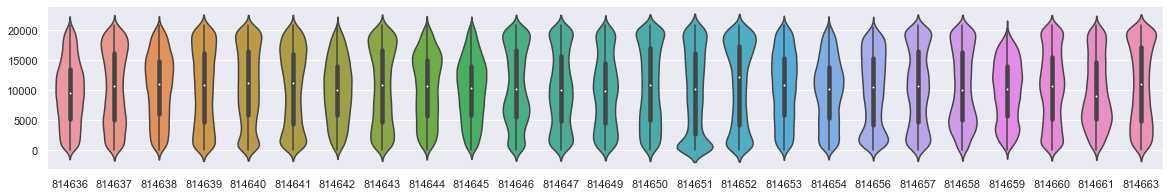

In [112]:
# Create Violin Plots
sns.set()
vioColnames= list(wholeAttedData.columns)
vioColnames = vioColnames[1:]
vioColnames
ax = plt.figure(figsize = (20,3))
ax =sns.violinplot(data = wholeAttedData[vioColnames[:25]])

In [29]:
# ATTED Degree-Rank based on MR
sumMR_WA = wholeAttedData.sum()
sumMR_WA = list(sumMR_A)
rank_sumMR_WA = sorted(sumMR_A, reverse = True)
# ATTED Degree-Count based on MR
binsize = 1000000
binMRW= (np.array(sumMR_WA)/binsize).astype('int')
attedCountW = collections.Counter(binMRW) 
MR_WA, cnt_WA = zip(*attedCountW.items())
n_binsW = len(MR_WA)

Text(0, 0.5, 'Count')

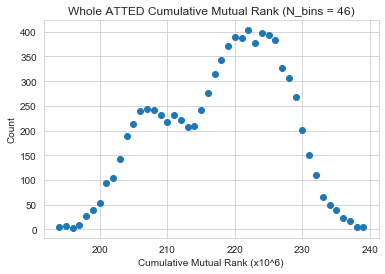

In [30]:
# Visualize MR distribution of ATTED (pseduo histogram)
sns.set_style('whitegrid')
plt.scatter(MR_WA,cnt_WA)
plt.title('Whole ATTED Cumulative Mutual Rank (N_bins = {})'.format(n_binsW))
plt.xlabel('Cumulative Mutual Rank (x10^{:.0f})'.format(np.log10(binsize)))
plt.ylabel('Count')

Text(0, 0.5, 'Count')

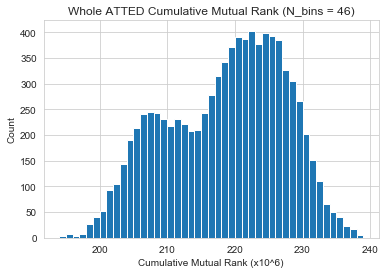

In [31]:
# Visualize MR distribution of ATTED (Histogram)
plt.hist(np.array(sumMR_WA)/1000000, bins = np.arange(194,240,1))
plt.title('Whole ATTED Cumulative Mutual Rank (N_bins = {})'.format(n_binsW))
plt.xlabel('Cumulative Mutual Rank (x10^{:.0f})'.format(np.log10(binsize)))
plt.ylabel('Count')

Text(0.5, 0, 'Rank')

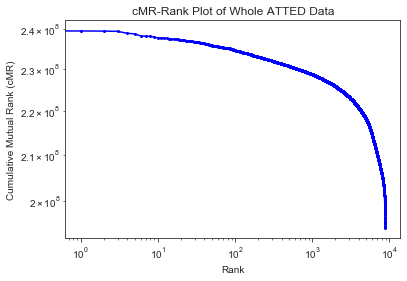

In [32]:
sns.set_style('ticks')
plt.loglog(rank_sumMR_WA, 'b-', marker='o', markersize = 2)
plt.title("cMR-Rank Plot of Whole ATTED Data") 
plt.ylabel("Cumulative Mutual Rank (cMR)")
plt.xlabel("Rank")

## Overlapping ATTED

In [20]:
# ATTED Degree-Rank based on MR
sumMR_A = attedData.sum()
sumMR_A = list(sumMR_A)
rank_sumMR_A = sorted(sumMR_A, reverse = True)
# ATTED Degree-Count based on MR
binsize = 1000000
binMR= (np.array(sumMR_A)/binsize).astype('int')
attedCount = collections.Counter(binMR) 
MR_A, cnt_A = zip(*attedCount.items())
n_bins = len(MR_A)

Text(0, 0.5, 'Count')

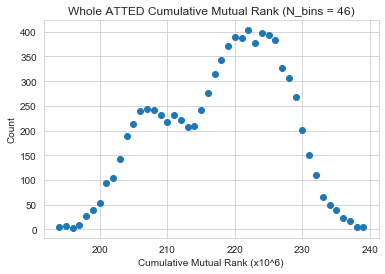

In [21]:
# Visualize MR distribution of ATTED (pseduo histogram)
sns.set_style('whitegrid')
plt.scatter(MR_A,cnt_A)
plt.title('Whole ATTED Cumulative Mutual Rank (N_bins = {})'.format(n_bins))
plt.xlabel('Cumulative Mutual Rank (x10^{:.0f})'.format(np.log10(binsize)))
plt.ylabel('Count')

Text(0, 0.5, 'Count')

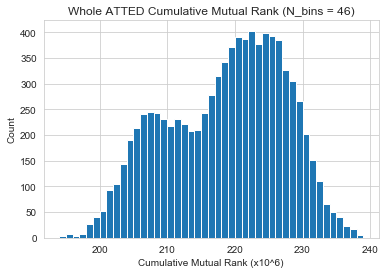

In [24]:
# Visualize MR distribution of ATTED (Histogram)
plt.hist(np.array(sumMR_A)/1000000, bins = np.arange(194,240,1))
plt.title('Whole ATTED Cumulative Mutual Rank (N_bins = {})'.format(n_bins))
plt.xlabel('Cumulative Mutual Rank (x10^{:.0f})'.format(np.log10(binsize)))
plt.ylabel('Count')

Text(0.5, 0, 'Rank')

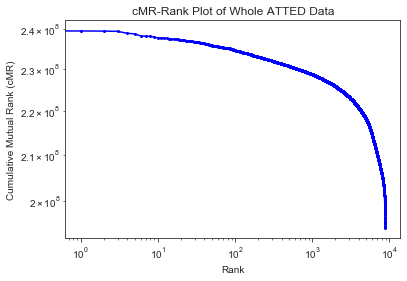

In [33]:
sns.set_style('ticks')
plt.loglog(rank_sumMR_A, 'b-', marker='o', markersize = 2)
plt.title("cMR-Rank Plot of Whole ATTED Data") 
plt.ylabel("Cumulative Mutual Rank (cMR)")
plt.xlabel("Rank")

## BioGRID

In [34]:
# BioGRID Degree-Rank based on MR
deg_Bio = [genesG.degree(gene) for gene in genesG.nodes] 
rank_deg_bio = sorted(deg_Bio, reverse = True)
# BioGRID Degree-Count
deg_Bio_count = collections.Counter(deg_Bio)
deg_B,cnt_B = zip(*deg_Bio_count.items())

Text(0, 0.5, 'Gene Count')

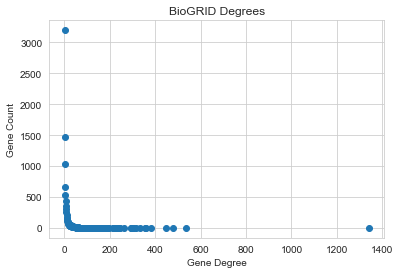

In [35]:
# Visualize degree distribution of BioGRID (psuedo bar plot)
sns.set_style('whitegrid')
sns.axes_style('ticks')
plt.scatter(deg_B,cnt_B)
plt.title('BioGRID Degrees')
plt.xlabel('Gene Degree')
plt.ylabel('Gene Count')

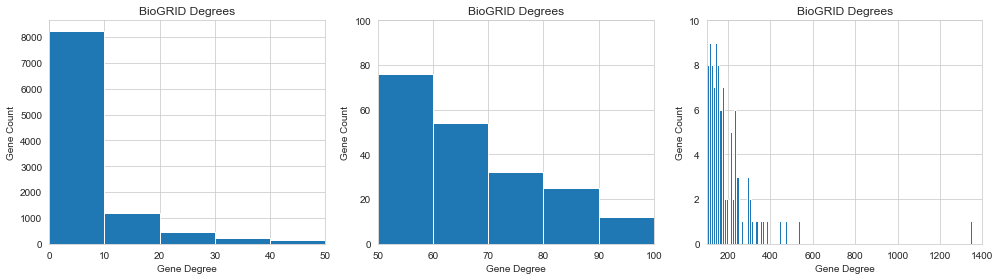

In [54]:
# Histogram Separated into 3 sections to see
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    axs[i].hist(deg_Bio, bins = np.arange(0,1500,10))
    axs[i].set_title('BioGRID Degrees')
    axs[i].set_xlabel('Gene Degree')
    axs[i].set_ylabel('Gene Count')
axs[0].set_xlim(0,50)
axs[1].set_xlim(50,100)
axs[1].set_ylim(0,100)
axs[2].set_xlim(100,1400)
axs[2].set_ylim(0,10)
plt.tight_layout()

Text(0.5, 0, 'Rank')

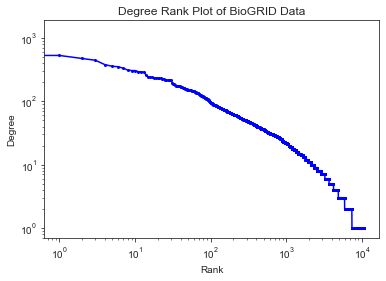

In [90]:
sns.set_style('ticks')
plt.loglog(rank_deg_bio, 'b-', marker='o', markersize = 2)
plt.title("Degree Rank Plot of BioGRID Data") 
plt.ylabel("Degree")
plt.xlabel("Rank")

In [97]:
# BioGRID ABC Degree-Rank based on MR
deg_BioABC = [genesG.degree(gene) for gene in abc] 
rank_deg_bioABC = sorted(deg_BioABC, reverse = True)
# BioGRID ABC Degree-Count
deg_Bio_countABC = collections.Counter(deg_BioABC)
deg_BABC,cnt_BABC = zip(*deg_Bio_countABC.items())

# BioGRID LTP Degree-Rank based on MR
deg_BioLTP = [genesG.degree(gene) for gene in ltp] 
rank_deg_bioLTP = sorted(deg_BioLTP, reverse = True)
# BioGRID LTP Degree-Count
deg_Bio_countLTP = collections.Counter(deg_BioLTP)
deg_BLTP,cnt_BLTP = zip(*deg_Bio_countLTP.items())

# BioGRID Both ABC,LTP Degree-Rank based on MR
deg_BioB = [genesG.degree(gene) for gene in abc+ltp] 
rank_deg_bioB = sorted(deg_BioB, reverse = True)
# BioGRID Both ABC,LTP Degree-Count
deg_Bio_countB = collections.Counter(deg_BioB)
deg_BB,cnt_BB = zip(*deg_Bio_countB.items())

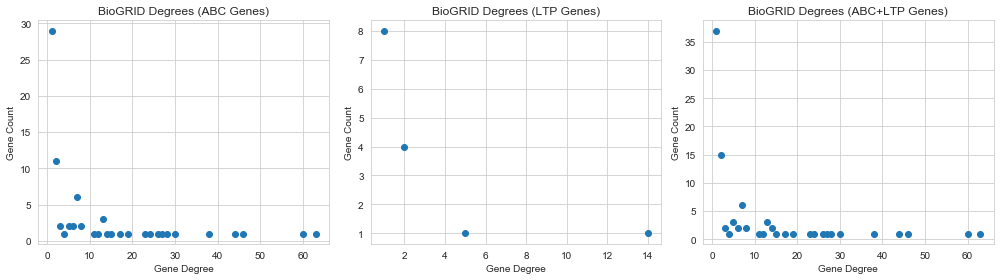

In [102]:
# Visualize degree distribution of BioGRID (psuedo bar plot)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.set_style('whitegrid')
sns.axes_style('ticks')
axs[0].scatter(deg_BABC,cnt_BABC)
axs[0].set_title('BioGRID Degrees (ABC Genes)')
axs[0].set_xlabel('Gene Degree')
axs[0].set_ylabel('Gene Count')
axs[1].scatter(deg_BLTP,cnt_BLTP)
axs[1].set_title('BioGRID Degrees (LTP Genes)')
axs[1].set_xlabel('Gene Degree')
axs[1].set_ylabel('Gene Count')
axs[2].scatter(deg_BB,cnt_BB)
axs[2].set_title('BioGRID Degrees (ABC+LTP Genes)')
axs[2].set_xlabel('Gene Degree')
axs[2].set_ylabel('Gene Count')
plt.tight_layout()

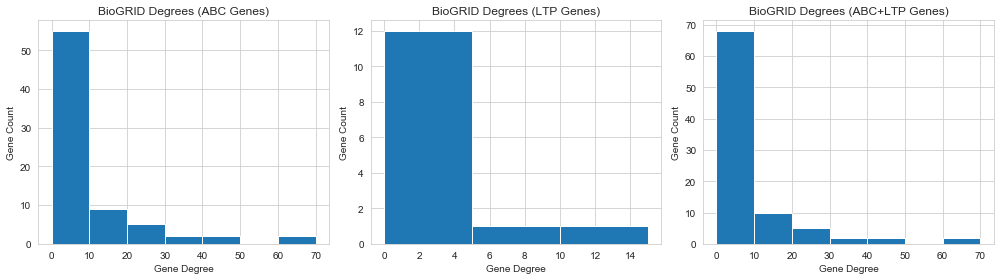

In [105]:
# Histogram Separated into 3 sections to see
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.set_style('whitegrid')
sns.axes_style('ticks')
axs[0].hist(deg_BioABC, bins = np.arange(0,71,10))
axs[0].set_title('BioGRID Degrees (ABC Genes)')
axs[0].set_xlabel('Gene Degree')
axs[0].set_ylabel('Gene Count')
axs[1].hist(deg_BioLTP, bins = np.arange(0,20,5))
axs[1].set_title('BioGRID Degrees (LTP Genes)')
axs[1].set_xlabel('Gene Degree')
axs[1].set_ylabel('Gene Count')
axs[2].hist(deg_BioB, bins = np.arange(0,71,10))
axs[2].set_title('BioGRID Degrees (ABC+LTP Genes)')
axs[2].set_xlabel('Gene Degree')
axs[2].set_ylabel('Gene Count')
plt.tight_layout()

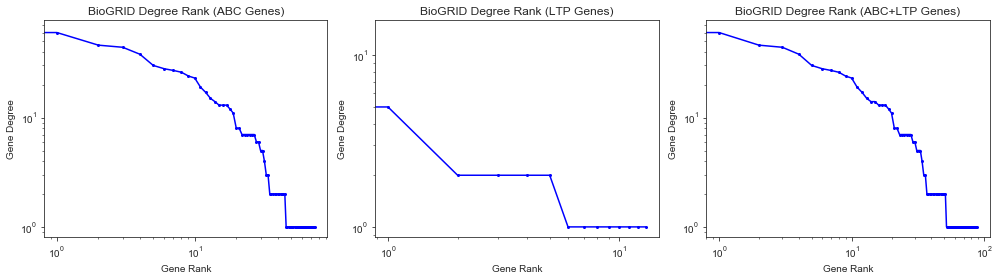

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.axes_style('ticks')
axs[0].loglog(rank_deg_bioABC, 'b-', marker='o', markersize = 2)
axs[0].set_title('BioGRID Degree Rank (ABC Genes)')
axs[0].set_xlabel('Gene Rank')
axs[0].set_ylabel('Gene Degree')
axs[1].loglog(rank_deg_bioLTP, 'b-', marker='o', markersize = 2)
axs[1].set_title('BioGRID Degree Rank (LTP Genes)')
axs[1].set_xlabel('Gene Rank')
axs[1].set_ylabel('Gene Degree')
axs[2].loglog(rank_deg_bioB, 'b-', marker='o', markersize = 2)
axs[2].set_title('BioGRID Degree Rank (ABC+LTP Genes)')
axs[2].set_xlabel('Gene Rank')
axs[2].set_ylabel('Gene Degree')
plt.tight_layout()